In [1]:
from matplotlib import pyplot as plt
from utils.utils import *
import utils.promethee_functions as pf
import utils.clustering_functions as cf
import utils.eval_metrics as em
from tslearn.clustering import TimeSeriesKMeans

utils.py Loading


In [2]:
def p2Kmeans(data, k, W, P, Q, N, K, L, PHI_df, proto=False, dist_func=cf.euclid_distance):
    """ 
    This function performs the Promethee II method on the data
    Then apply the K-means clustering algorithm on the results
    
    Parameters:
    data (DataFrame): The data to be processed
    W (list): The weights of the criteria
    P (list): The preference function parameters
    Q (list): The indifference function parameters
    K (int): The number of criteria
    L (int): The length of the time series
    """
    results = cf.kMeans(PHI_df, k, max_it=100, distance_function=dist_func, random_selec=proto)

    # Get a list of list of ISO3 codes for each cluster
    clusters = []
    for i in range(k):
        clusters.append(results[i].index.tolist())
    # print(clusters)

    return clusters

In [3]:
def KMeans_auto(PHI_df, k, metrics="euclidean", proto="k-means++"):
    formatted_data = np.array([PHI_df.loc[iso3].values for iso3 in PHI_df.index])
    names = PHI_df.index

    km = TimeSeriesKMeans(n_clusters=k, metric=metrics, init=proto, max_iter=100).fit(formatted_data)

    clusters = {i: [] for i in range(k)}
    for i, label in enumerate(km.labels_):
        clusters[label].append(names[i])

    list_clusters = [clusters[i] for i in range(k)]
    return list_clusters
    

In [4]:
def p2km_compare_algos(data, k, n_try, W, N, L, K, P, Q):
    """ 
        Compare algorithms parameters for p2km clustering
        k: number of clusters
        n_try: number of tries
    """
    dunn_km_random = []
    dunn_km_kmplus = []
    dunn_km_man_rand = []
    dunn_km_man_farth = []
    dunn_km_man_rand_dtw = []
    dunn_km_kmplus_dtw = []
    dunn_km_kmplus_sdtw = []
    
    phi_c_all = pf.get_all_Phi_c(data, P, Q, L) # compute all mono criterion flows series
    PHI = pf.PHI_all(phi_c_all, W, N, L, K) # Aggregate to the net flow series
    # Transform PHI into a dataframe with ISO3 as index and years as columns
    PHI_df = pd.DataFrame(PHI, index=data.index, columns=np.arange(1990, 2023))

    for i in tqdm(range(n_try), desc="Manual Random initialization"):
        clusters_random = p2Kmeans(data, k, W, P, Q, N, K, L, PHI_df, proto=True)
        dunn_km_man_rand.append(em.dunn_index_multivariate(clusters_random, data))
        
    for i in tqdm(range(n_try), desc="Manual Farthest initialization"):
        clusters_farthest = p2Kmeans(data, k, W, P, Q, N, K, L, PHI_df, proto=False)
        dunn_km_man_farth.append(em.dunn_index_multivariate(clusters_farthest, data))

    for i in tqdm(range(n_try), desc="Manual Random initialization with DTW"):
        clusters_random_dtw = p2Kmeans(data, k, W, P, Q, N, K, L, PHI_df, proto=True, dist_func=cf.dynamic_time_warping)
        dunn_km_man_rand_dtw.append(em.dunn_index_multivariate(clusters_random_dtw, data))

    for i in tqdm(range(n_try), desc="K-means++ initialization"):
        KMeans_auto(PHI_df, k, proto="k-means++")
        dunn_km_kmplus.append(em.dunn_index_multivariate(clusters_random, data))

    for i in tqdm(range(n_try), desc="Random initialization"):
        KMeans_auto(PHI_df, k, proto="random")
        dunn_km_random.append(em.dunn_index_multivariate(clusters_random, data))

    for i in tqdm(range(n_try), desc="K-means++ initialization with DTW"):
        KMeans_auto(PHI_df, k, proto="k-means++", metrics="dtw")
        dunn_km_kmplus_dtw.append(em.dunn_index_multivariate(clusters_random, data))

    for i in tqdm(range(n_try), desc="K-means++ initialization with Soft-DTW"):
        KMeans_auto(PHI_df, k, proto="k-means++", metrics="softdtw")
        dunn_km_kmplus_sdtw.append(em.dunn_index_multivariate(clusters_random, data))

    return dunn_km_random, dunn_km_kmplus, dunn_km_kmplus_dtw, dunn_km_kmplus_sdtw, dunn_km_man_rand, dunn_km_man_farth, dunn_km_man_rand_dtw

In [5]:
def analyze_results(dunn1, dunn2, dunn3, dunn4, dunn5, dunn6, dunn7):
    """
    Analyze the results of the clustering algorithms
    """
    dunn1 = np.array(dunn1)
    dunn2 = np.array(dunn2)
    dunn3 = np.array(dunn3)
    dunn4 = np.array(dunn4)
    dunn5 = np.array(dunn5)
    dunn6 = np.array(dunn6)
    dunn7 = np.array(dunn7)

    # Plot boxplots for each algorithm (on the same plot)
    plt.figure(figsize=(14, 6))

    plt.boxplot([dunn1, dunn2, dunn3, dunn4, dunn5, dunn6, dunn7], tick_labels=["Random", "Km++", "Km++ DTW", "Km++ Soft DTW",  "Random Manual", "Farthest Manual", "Random Manual DTW"])
    plt.title("Analysis of Dunn index for different initialization methods of the P2KM algorithm")
    plt.show()

In [6]:
data = read_data()
# Nb of criteria
K = data.columns.shape[0] # Nb of criteria
L = data.iloc[0]["co2prod"].shape[0] # Length of the time series
N = data.shape[0] # Nb of alternatives

W = [1/K for i in range(K)] # Weights of the criteria (equal weights)
Q = [1, 0.03, 5, 0.01, 0.5, 0.5] # Indifference thresholds
P = [10, 0.4, 20, 0.3, 5, 5]

group0 = ["PAK", "SDN", "BDI", "HTI"]
group1 = ["EST", "CZE", "MLT", "SGP", "IRL"]
group2 = ["CHE", "ISL", "NZL", "SWE"]
all_groups = group0 + group1 + group2
data = data.loc[all_groups]
N = data.shape[0]

Reading HDI dataset
co2prod: min=0.0, max=33.3863
hdi: min=0.257, max=0.967
le: min=37.105, max=85.473
gdi: min=0.383, max=1.041
eys: min=3.5751, max=23.2477
mys: min=1.4606, max=14.2559


In [7]:
k = 3
n_try = 5
dunn1, dunn2, dunn3, dunn4, dunn5, dunn6, dunn7 = p2km_compare_algos(data, k, n_try, W, N, L, K, P, Q)

c:\Users\raphu\Documents\ULB\MA2\ulb-master-thesis\code\src\utils\promethee_functions.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]
Manual Random initialization:   0%|          | 0/5 [00:00<?, ?it/s]

K-means++ initialization with Soft-DTW: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


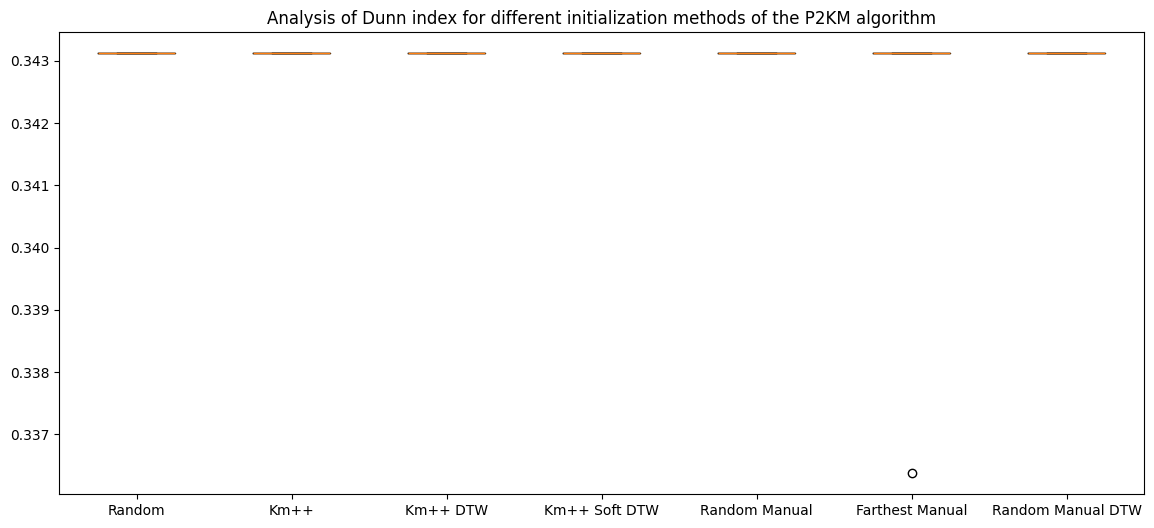

In [8]:
analyze_results(dunn1, dunn2, dunn3, dunn4, dunn5, dunn6, dunn7)


Reading HDI dataset
co2prod: min=0.0, max=33.3863
hdi: min=0.257, max=0.967
le: min=37.105, max=85.473
gdi: min=0.383, max=1.041
eys: min=3.5751, max=23.2477
mys: min=1.4606, max=14.2559


c:\Users\raphu\Documents\ULB\MA2\ulb-master-thesis\code\src\utils\promethee_functions.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]
K-means++ initialization with Soft-DTW: 100%|██████████| 10/10 [01:00<00:00,  6.09s/it]


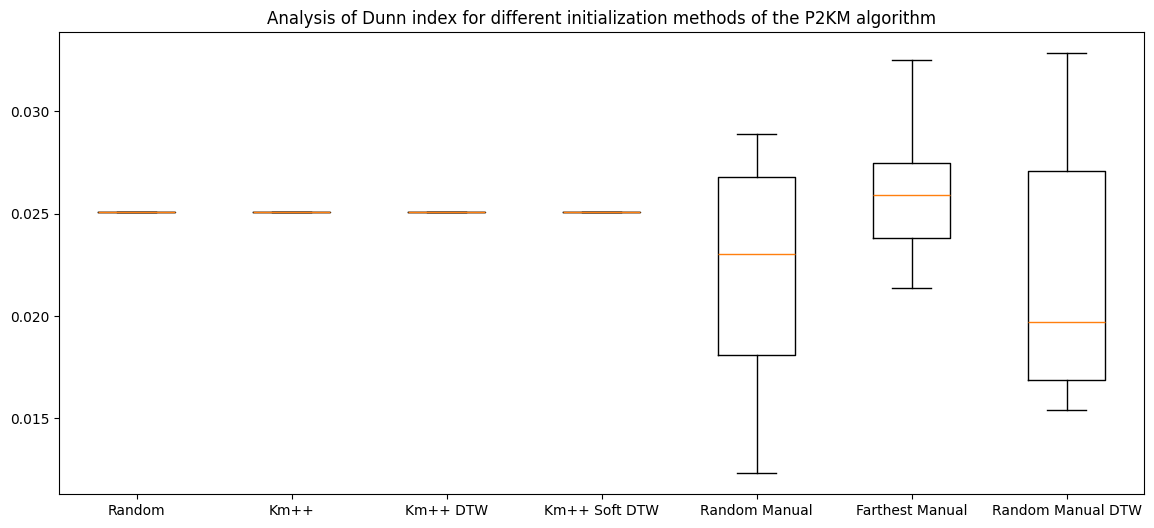

: 

In [ ]:
data = read_data()
# Nb of criteria
K = data.columns.shape[0] # Nb of criteria
L = data.iloc[0]["co2prod"].shape[0] # Length of the time series
N = data.shape[0] # Nb of alternatives

k = 10
n_try = 10
dunn1, dunn2, dunn3, dunn4, dunn5, dunn6, dunn7 = p2km_compare_algos(data, k, n_try, W, N, L, K, P, Q)

analyze_results(dunn1, dunn2, dunn3, dunn4, dunn5, dunn6, dunn7)